# Transfer Learning Model

Setup

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [8]:
# Set the path to the data directory
data_address = os.path.join(os.getcwd(),'../..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))

In [9]:
# Get the image paths
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


In [10]:
# Function for plotting images
plots_dir = "../plots"
os.makedirs(plots_dir,exist_ok=True)
#plot accuracy curves
def plot_fig(i, history, model):
    fig = plt.figure()
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0, label='validation')
    plt.plot(history.history['accuracy'],'r',linewidth=3.0,label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.title("Model Accuracy" + str(model))
    plt.show()
    fig.savefig(os.path.join(plots_dir, str(i)+'-accuracy.jpg'))
    plt.close(fig)

Preprocess Data

In [11]:
# modeling parameters
train_arrays = []
size = (256, 256)
batch_size = 32

In [12]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Degree range for random rotations
    width_shift_range=0.2,    # Range for horizontal shift
    height_shift_range=0.2,   # Range for vertical shift
    shear_range=0.2,          # Shear intensity range
    zoom_range=0.2,           # Range for random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=False       # Do not flip images vertically
)


In [13]:
# Load the training data
training_label.dropna()
for x in training_label['X_ray_image_name']:
    try:
        img_path = os.path.join(image_address, 'train', x)
        img = image.load_img(img_path, target_size=size)
        img_array = image.img_to_array(img)
        train_arrays.append(img_array)
    except Exception as e:
        print(f"Error loading image: {img_path}")
        # Handle the exception or skip the image if necessary

In [14]:
# Convert train_arrays and label to NumPy arrays
train_images = np.array(train_arrays)
label_mapping = {"Pnemonia": 1, "Normal": 0}
label = training_label['Label'].map(label_mapping)
train_images = train_images.astype('float32') / 255.0


In [15]:
# Split the data into training and validation sets
augmented_images = datagen.flow(train_images, label, batch_size=batch_size)
augmented_train_images = []
augmented_labels = []

for images, labels in augmented_images:
    augmented_train_images.append(images)
    augmented_labels.append(labels)
    if len(augmented_train_images) >= len(train_images) / batch_size:
        break

augmented_train_images = np.concatenate(augmented_train_images)
augmented_labels = np.concatenate(augmented_labels)


In [16]:
# Split the data into training and validation sets
train_images = np.concatenate((train_images, augmented_train_images))
labels = np.concatenate((label, augmented_labels))

train_images, val_images, train_labels, val_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)
final_train_images, val_images, final_train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



# Modeling

## ResNet Model

In [17]:
# Define the input size
epochs = 50
batch_size = 32
input_shape = (256, 256, 3)
num_classes = 2
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
validation_data = (val_images, val_labels)


In [12]:
# Build the ResNet model
base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False

# Add custom head to the base model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

validation_data = (val_images, val_labels)
history_resnet = model.fit(final_train_images, final_train_labels, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


2023-05-21 22:08:48.893698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7341 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1
2023-05-21 22:08:48.894253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7349 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:06:00.0, compute capability: 6.1
2023-05-21 22:08:48.894684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 7349 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1
2023-05-21 22:08:48.895070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 7349 MB memory:  -> device: 3, name: NVIDIA GeForce GTX 1080, pc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                             

2023-05-21 22:08:59.287153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-21 22:08:59.705644: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-21 22:09:00.751101: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 22:09:00.783571: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 22:09:00.791305: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa19c83e740 initialized for platform CUDA 

212/212 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7336

2023-05-21 22:09:28.465881: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 601.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 22:09:28.545912: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 763.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-21 22:09:28.593289: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 775.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


212/212 [==============================] - 33s 132ms/step - loss: 0.5791 - accuracy: 0.7336 - val_loss: 0.5033 - val_accuracy: 0.7843
Epoch 2/50
  1/212 [..............................] - ETA: 19s - loss: 0.4922 - accuracy: 0.7500

2023-05-21 22:09:29.156062: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


212/212 [==============================] - 25s 117ms/step - loss: 0.4884 - accuracy: 0.7642 - val_loss: 0.4345 - val_accuracy: 0.7642
Epoch 3/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4316 - accuracy: 0.7920 - val_loss: 0.4061 - val_accuracy: 0.7914
Epoch 4/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4314 - accuracy: 0.7910 - val_loss: 0.4277 - val_accuracy: 0.7506
Epoch 5/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4181 - accuracy: 0.7973 - val_loss: 0.3933 - val_accuracy: 0.7943
Epoch 6/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4132 - accuracy: 0.7957 - val_loss: 0.3938 - val_accuracy: 0.7624
Epoch 7/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4083 - accuracy: 0.8034 - val_loss: 0.3795 - val_accuracy: 0.8002
Epoch 8/50
212/212 [==============================] - 25s 117ms/step - loss: 0.4252 - accuracy: 0.7929 - val_loss: 0.3802 - val_accuracy: 0.8

Text(0.5, 1.0, 'Loss Curves')

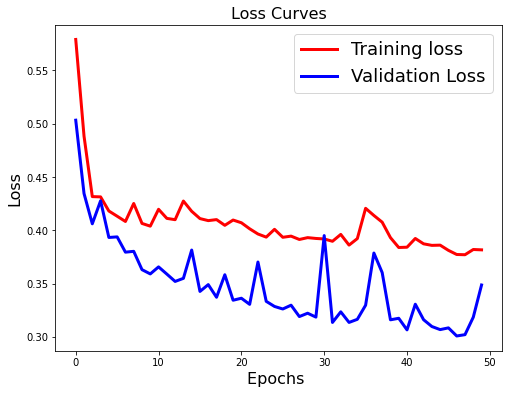

In [13]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_resnet.history['loss'],'r',linewidth=3.0)
plt.plot(history_resnet.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

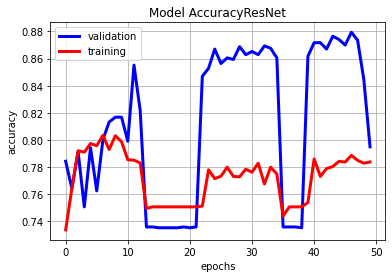

In [14]:
plot_fig(1, history_resnet, 'ResNet')

53/53 [==============================] - 4s 84ms/step
Accuracy:  0.7949172576832151

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.31      0.44       446
           1       0.80      0.97      0.87      1246

    accuracy                           0.79      1692
   macro avg       0.79      0.64      0.66      1692
weighted avg       0.79      0.79      0.76      1692

53/53 [==============================] - 4s 84ms/step
Confusion Matrix:
[[ 137  309]
 [  38 1208]]
53/53 [==============================] - 4s 84ms/step


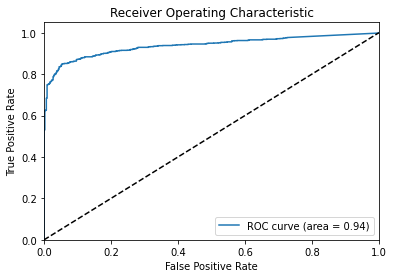

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


class_names = ["Normal", "Pneumonia"]
# Predict classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Accuracy, F1 Score, Precision, Recall
print("Accuracy: ", accuracy_score(val_labels, y_pred_classes))
print('\nClassification Report')
print(classification_report(val_labels, y_pred_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)


# ROC Curve 
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_probs = model.predict(val_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## VGG

In [18]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


2023-05-21 23:39:38.641199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-21 23:39:38.642135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 41385 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-21 23:39:38.642755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 45013 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-21 23:39:38.643382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 45013 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)

# Train the model with data
history_vgg = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Epoch 1/50


2023-05-21 23:39:52.211129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-21 23:39:53.001141: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-21 23:39:53.544788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-21 23:39:53.863633: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x557af4b37ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 23:39:53.863664: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-05-21 23:39:53.863670: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-05-21 23:39:53.863674: I tensorflow/compiler/xla/service/service

212/212 [==============================] - 25s 87ms/step - loss: 0.3135 - accuracy: 0.8551 - val_loss: 0.2424 - val_accuracy: 0.9013
Epoch 2/50
212/212 [==============================] - 15s 73ms/step - loss: 0.2015 - accuracy: 0.9180 - val_loss: 0.1743 - val_accuracy: 0.9362
Epoch 3/50
212/212 [==============================] - 15s 72ms/step - loss: 0.1702 - accuracy: 0.9314 - val_loss: 0.1557 - val_accuracy: 0.9391
Epoch 4/50
212/212 [==============================] - 15s 72ms/step - loss: 0.1512 - accuracy: 0.9387 - val_loss: 0.1405 - val_accuracy: 0.9468
Epoch 5/50
212/212 [==============================] - 16s 75ms/step - loss: 0.1443 - accuracy: 0.9432 - val_loss: 0.1284 - val_accuracy: 0.9509
Epoch 6/50
212/212 [==============================] - 15s 73ms/step - loss: 0.1334 - accuracy: 0.9494 - val_loss: 0.1619 - val_accuracy: 0.9344
Epoch 7/50
212/212 [==============================] - 16s 76ms/step - loss: 0.1269 - accuracy: 0.9493 - val_loss: 0.1212 - val_accuracy: 0.9586
Epo

Text(0.5, 1.0, 'Loss Curves')

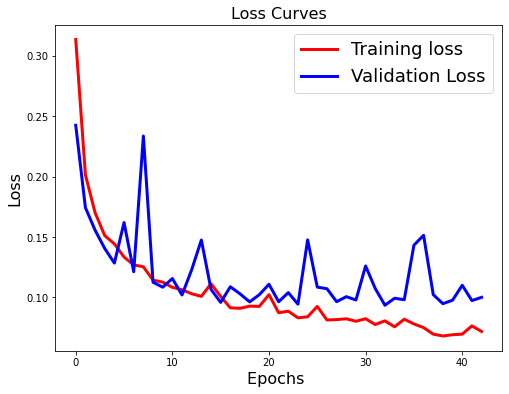

In [20]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

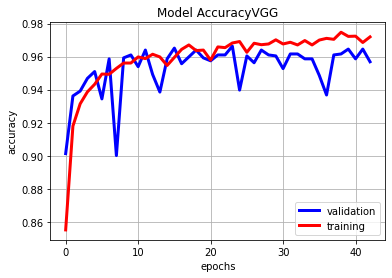

In [21]:
# plot accuracy
plot_fig(2, history_vgg, 'VGG')

53/53 [==============================] - 3s 60ms/step
Accuracy:  0.956855791962175

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       465
           1       0.98      0.96      0.97      1227

    accuracy                           0.96      1692
   macro avg       0.94      0.95      0.95      1692
weighted avg       0.96      0.96      0.96      1692

53/53 [==============================] - 3s 49ms/step
Confusion Matrix:
[[ 441   24]
 [  49 1178]]
53/53 [==============================] - 3s 49ms/step


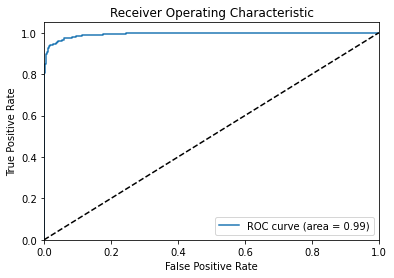

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["Normal", "Pneumonia"]
# Predict classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Accuracy, F1 Score, Precision, Recall
print("Accuracy: ", accuracy_score(val_labels, y_pred_classes))
print('\nClassification Report')
print(classification_report(val_labels, y_pred_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)


# ROC Curve 
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_probs = model.predict(val_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## EfficientNet Model

In [23]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)   

In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data
# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)
history_en = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Epoch 1/50
212/212 [==============================] - 22s 68ms/step - loss: 0.5664 - accuracy: 0.7542 - val_loss: 0.6169 - val_accuracy: 0.7252
Epoch 2/50
212/212 [==============================] - 12s 57ms/step - loss: 0.5648 - accuracy: 0.7542 - val_loss: 0.5890 - val_accuracy: 0.7252
Epoch 3/50
212/212 [==============================] - 12s 55ms/step - loss: 0.5634 - accuracy: 0.7542 - val_loss: 0.5880 - val_accuracy: 0.7252
Epoch 4/50
212/212 [==============================] - 11s 54ms/step - loss: 0.5614 - accuracy: 0.7542 - val_loss: 0.5906 - val_accuracy: 0.7252
Epoch 5/50
212/212 [==============================] - 12s 57ms/step - loss: 0.5600 - accuracy: 0.7542 - val_loss: 0.5901 - val_accuracy: 0.7252
Epoch 6/50
212/212 [==============================] - 11s 54ms/step - loss: 0.5597 - accuracy: 0.7542 - val_loss: 0.5880 - val_accuracy: 0.7252
Epoch 7/50
212/212 [==============================] - 12s 55ms/step - loss: 0.5603 - accuracy: 0.7542 - val_loss: 0.5881 - val_accuracy:

Text(0.5, 1.0, 'Loss Curves')

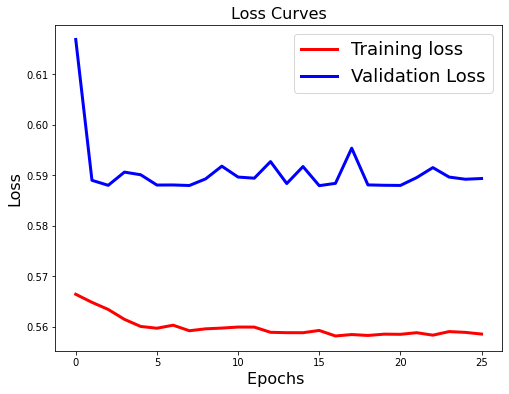

In [25]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_en.history['loss'],'r',linewidth=3.0)
plt.plot(history_en.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

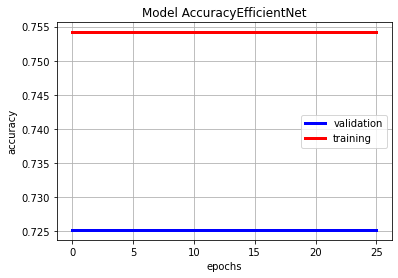

In [26]:
# plot accuracy
plot_fig(3, history_en, 'EfficientNet')

53/53 [==============================] - 3s 34ms/step
Accuracy:  0.725177304964539

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.73      1.00      0.84      1227

    accuracy                           0.73      1692
   macro avg       0.36      0.50      0.42      1692
weighted avg       0.53      0.73      0.61      1692



/nfs/home/hld9606/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nfs/home/hld9606/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nfs/home/hld9606/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 2s 33ms/step
Confusion Matrix:
[[   0  465]
 [   0 1227]]
53/53 [==============================] - 2s 33ms/step


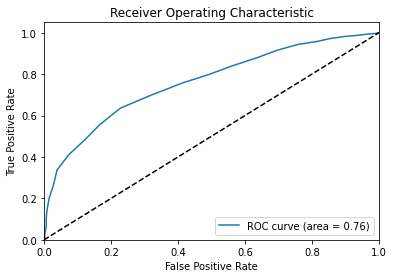

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["Normal", "Pneumonia"]
# Predict classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Accuracy, F1 Score, Precision, Recall
print("Accuracy: ", accuracy_score(val_labels, y_pred_classes))
print('\nClassification Report')
print(classification_report(val_labels, y_pred_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)


# ROC Curve 
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_probs = model.predict(val_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# DenseNet Model

In [28]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)
# Train the model with data
history_dn = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

Text(0.5, 1.0, 'Loss Curves')

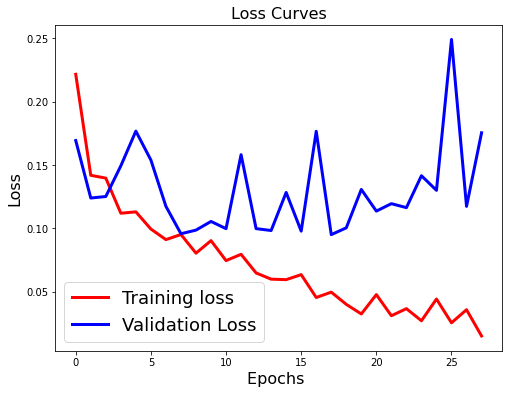

In [29]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_dn.history['loss'],'r',linewidth=3.0)
plt.plot(history_dn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

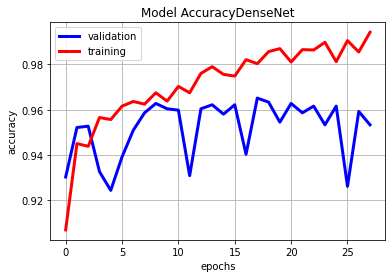

In [30]:
# plot accuracy
plot_fig(4, history_dn, 'DenseNet')

53/53 [==============================] - 4s 44ms/step
Accuracy:  0.9533096926713948

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       465
           1       0.95      0.99      0.97      1227

    accuracy                           0.95      1692
   macro avg       0.96      0.93      0.94      1692
weighted avg       0.95      0.95      0.95      1692

53/53 [==============================] - 2s 43ms/step
Confusion Matrix:
[[ 402   63]
 [  16 1211]]
53/53 [==============================] - 2s 42ms/step


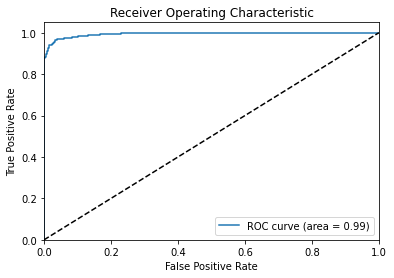

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["Normal", "Pneumonia"]
# Predict classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print Accuracy, F1 Score, Precision, Recall
print("Accuracy: ", accuracy_score(val_labels, y_pred_classes))
print('\nClassification Report')
print(classification_report(val_labels, y_pred_classes))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Predict classes
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)


# ROC Curve 
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_probs = model.predict(val_images)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(val_labels, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()